In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import os
from os.path import exists

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

from laos_gggi import load_ocean_heat_data, load_co2_data

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [3]:
df_ocean = load_ocean_heat_data()
df_co2 = load_co2_data()

In [4]:
df_ocean = 100*(df_ocean - df_ocean.mean())/df_ocean.std()
df_co2 = 100*(df_co2 - df_co2.mean())/df_co2.std()

In [5]:
df = pd.DataFrame.merge(df_ocean,df_co2,how='inner',left_index=True, right_index=True).dropna()

# Ocean Quadratic

<Axes: xlabel='Date'>

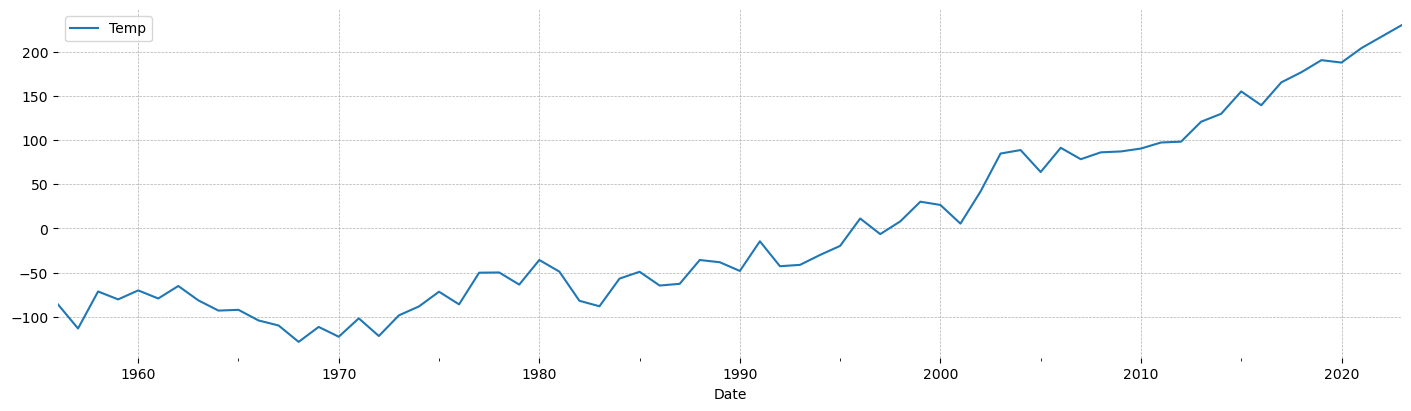

In [6]:
df_ocean.plot()

In [149]:
train_samples = int(df.shape[0] * 0.85)
train_df = df.iloc[:train_samples]
test_df = df.iloc[train_samples:]

# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)
SAMPLER_KWARGS = dict(nuts_sampler='nutpie', chains=8, draws=500)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords = {'time':train_df.index,
          'variable': ['ocean_temp', 'co2']}

In [26]:
with pm.Model(coords=coords) as deterministic_trend_mod:
    y_obs = pm.Data('y_obs', train_df.values, dims=['time', 'variable'])
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=-100, sigma=10, dims=['variable'])
    beta = pm.Normal('beta', mu=0, sigma=10, dims=['variable'])
    delta = pm.Normal('delta', mu=0, sigma=10, dims=['variable'])
    
    mu = pm.Deterministic('mu', (alpha[None] + 
                                 beta * t[:, None] + 
                                 delta * t[:, None] ** 2), 
                          dims=['time', 'variable'])
    sigma = pm.HalfNormal('sigma', sigma=1, dims=['variable'])

    y_hat = pm.Normal('y_hat', 
                      mu=mu,
                      sigma=sigma, 
                      observed=y_obs, 
                      shape=(t.shape[0], 2),
                      dims=['time', 'variable'])
    
    det_trend_idata = pm.sample(**SAMPLER_KWARGS)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.34,31
,1500,0,0.34,31
,1500,0,0.32,15
,1500,0,0.32,15
,1500,0,0.32,15
,1500,0,0.34,7
,1500,0,0.33,15
,1500,0,0.34,15


Sampling: [y_hat]


Output()

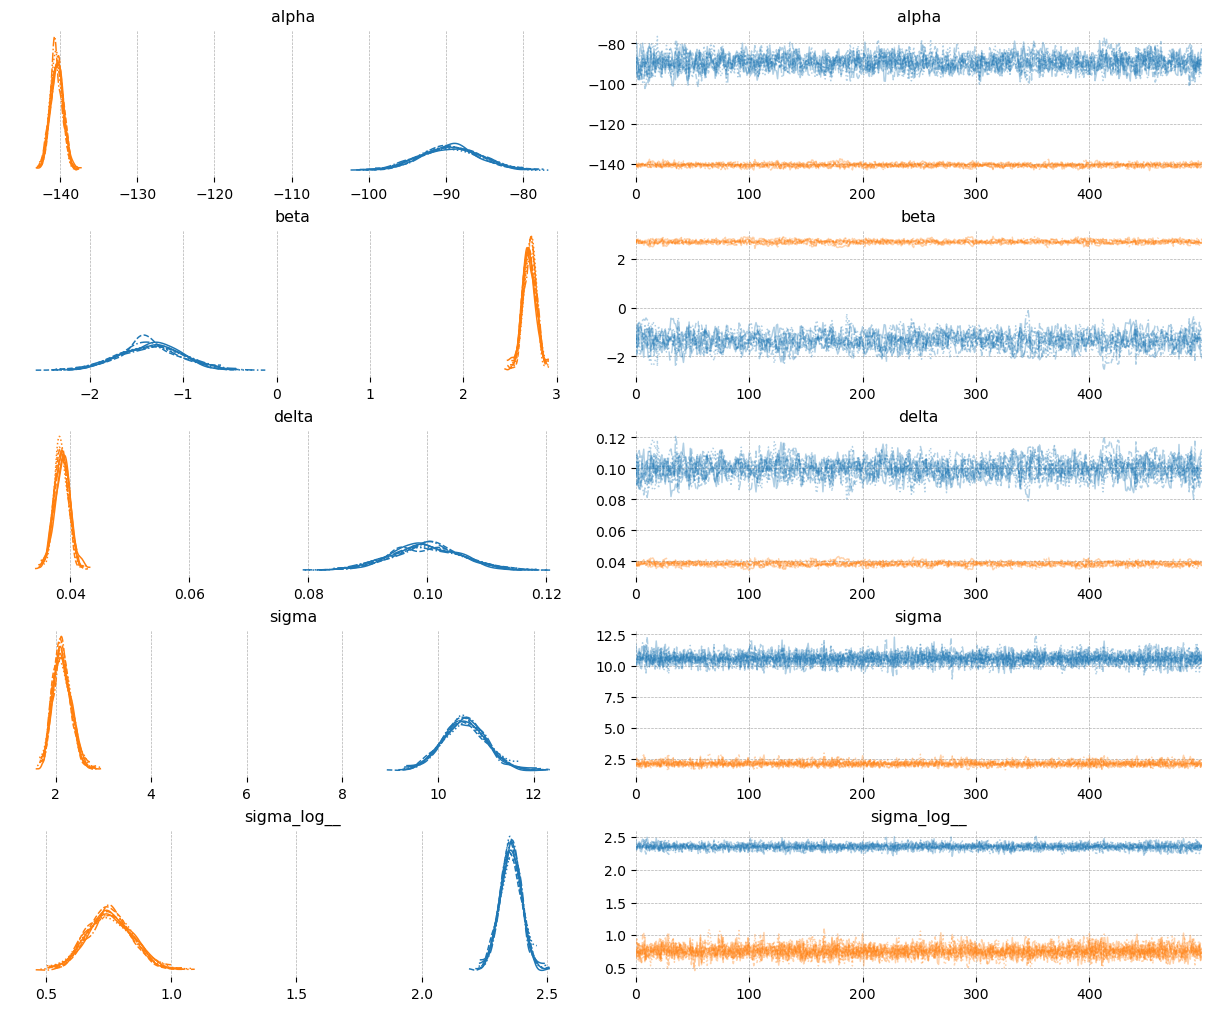

In [27]:
az.plot_trace(det_trend_idata, var_names=['~mu']);

In [28]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

Sampling: [y_hat]


Output()

In [37]:
getattr(det_trend_idata, 'posterior_predictive').sel(variable='co2')

<xarray.Dataset> Size: 2MB
Dimensions:   (chain: 8, draw: 500, time: 55)
Coordinates:
  * chain     (chain) int64 64B 0 1 2 3 4 5 6 7
  * draw      (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * time      (time) datetime64[ns] 440B 1959-01-01 1960-01-01 ... 2013-01-01
    variable  <U10 40B 'co2'
Data variables:
    y_hat     (chain, draw, time) float64 2MB -139.7 -137.9 ... 117.1 118.5
Attributes:
    created_at:                 2024-07-26T08:31:26.823734+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.16.2

In [40]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'observed_data']
    var_names = ['y_hat', 'y_hat', 'y_hat']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

def plot_predictions(idata, obs_name):
    fig, ax = plt.subplots()
    for group, var_name, label, var_color in make_plot_iter():
        data = getattr(idata, group).sel(variable=obs_name)
        time_values = data.coords['time'].values
        if group != 'observed_data':
            hdi = az.hdi(data)[var_name]
            data = data.mean(dim=['chain', 'draw'])
            ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
        ax.plot(time_values, data[var_name].values, c=var_color, label=label)
        ax.legend(fontsize=16)

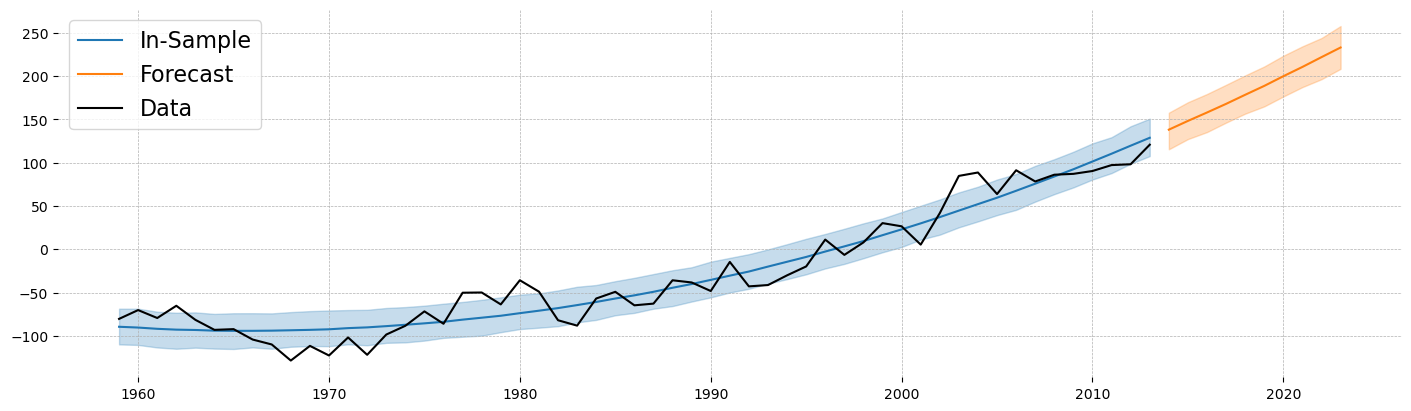

In [42]:
plot_predictions(det_trend_idata, 'ocean_temp')

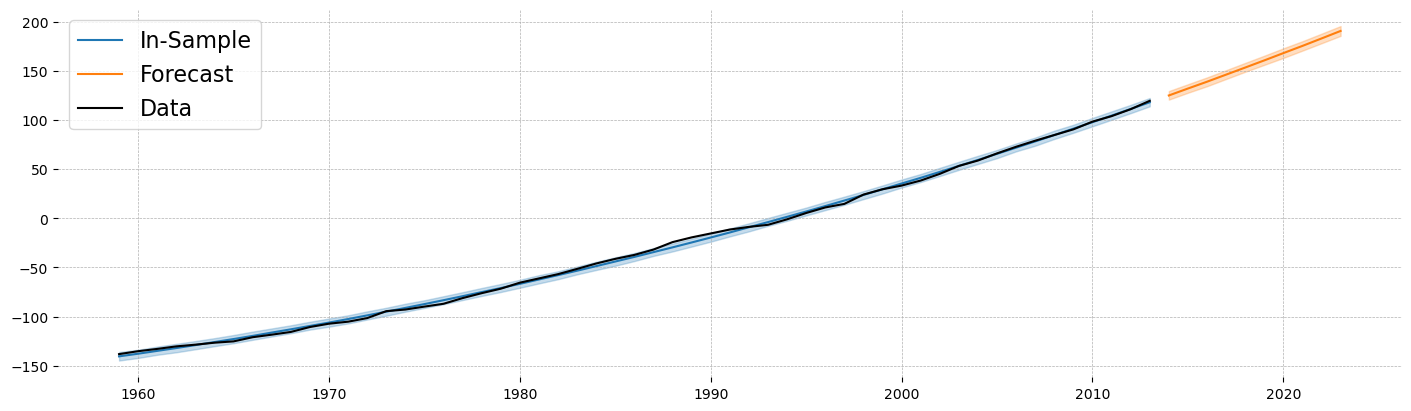

In [41]:
plot_predictions(det_trend_idata, 'co2')

# Combined

<Axes: xlabel='Date'>

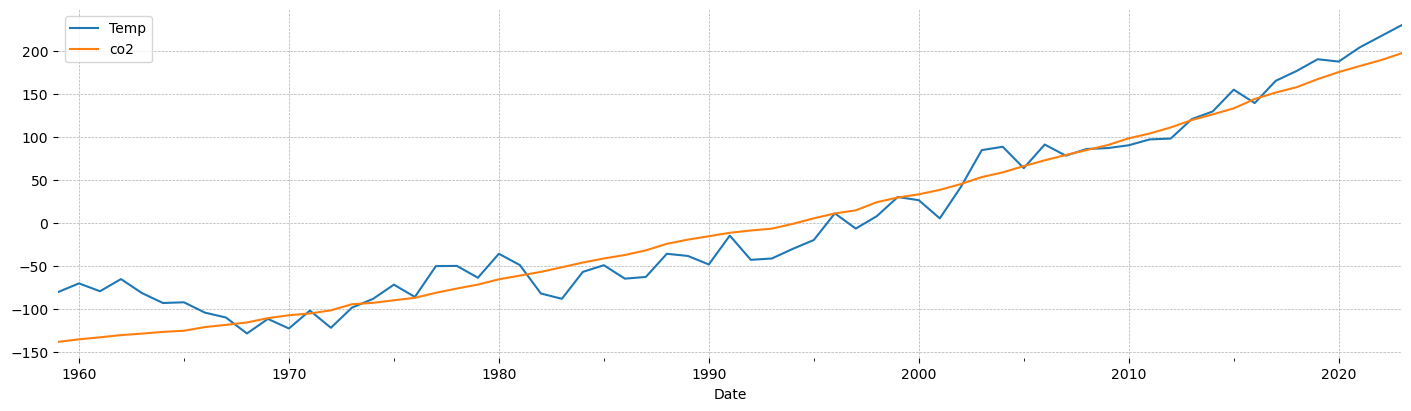

In [43]:
df.plot()

In [61]:
coords.update({'variable_aux': coords['variable']})
SAMPLER_KWARGS.update({'nuts_sampler':'numpyro'})

with pm.Model(coords=coords) as SUR_model:
    y_obs = pm.Data('y_obs', train_df.values, dims=['time', 'variable'])
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=-100, sigma=10, dims=['variable'])
    beta = pm.Normal('beta', mu=0, sigma=10, dims=['variable'])
    delta = pm.Normal('delta', mu=0, sigma=10, dims=['variable'])
    
    mu = pm.Deterministic('mu', (alpha[None] + 
                                 beta * t[:, None] + 
                                 delta * t[:, None] ** 2), 
                          dims=['time', 'variable'])
    # Define the covariance matrix for the errors
    sd_dist = pm.HalfNormal.dist(1.0)
    chol, corr, sigmas = pm.LKJCholeskyCov(
        'chol_cov', n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )
    pm.Deterministic('cov', chol @ chol.T, dims=['variable', 'variable_aux'])
    
    y_hat = pm.MvNormal('y_hat', 
                      mu=mu,
                      chol=chol, 
                      observed=y_obs, 
                      shape=(t.shape[0], 2),
                      dims=['time', 'variable'])
    
    SUR_idata = pm.sample(**SAMPLER_KWARGS)
    SUR_idata = pm.sample_posterior_predictive(SUR_idata, **POST_PRED_KWARGS, compile_kwargs={'mode':'JAX'})

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [y_hat]


Output()

In [65]:
from pymc.model.transform.optimization import freeze_dims_and_data
with SUR_model:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    SUR_idata = pm.sample_posterior_predictive(SUR_idata, predictions=True, **POST_PRED_KWARGS,
                                              compile_kwargs={'mode':'JAX'})

/Users/jessegrabowski/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2A87E51C0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

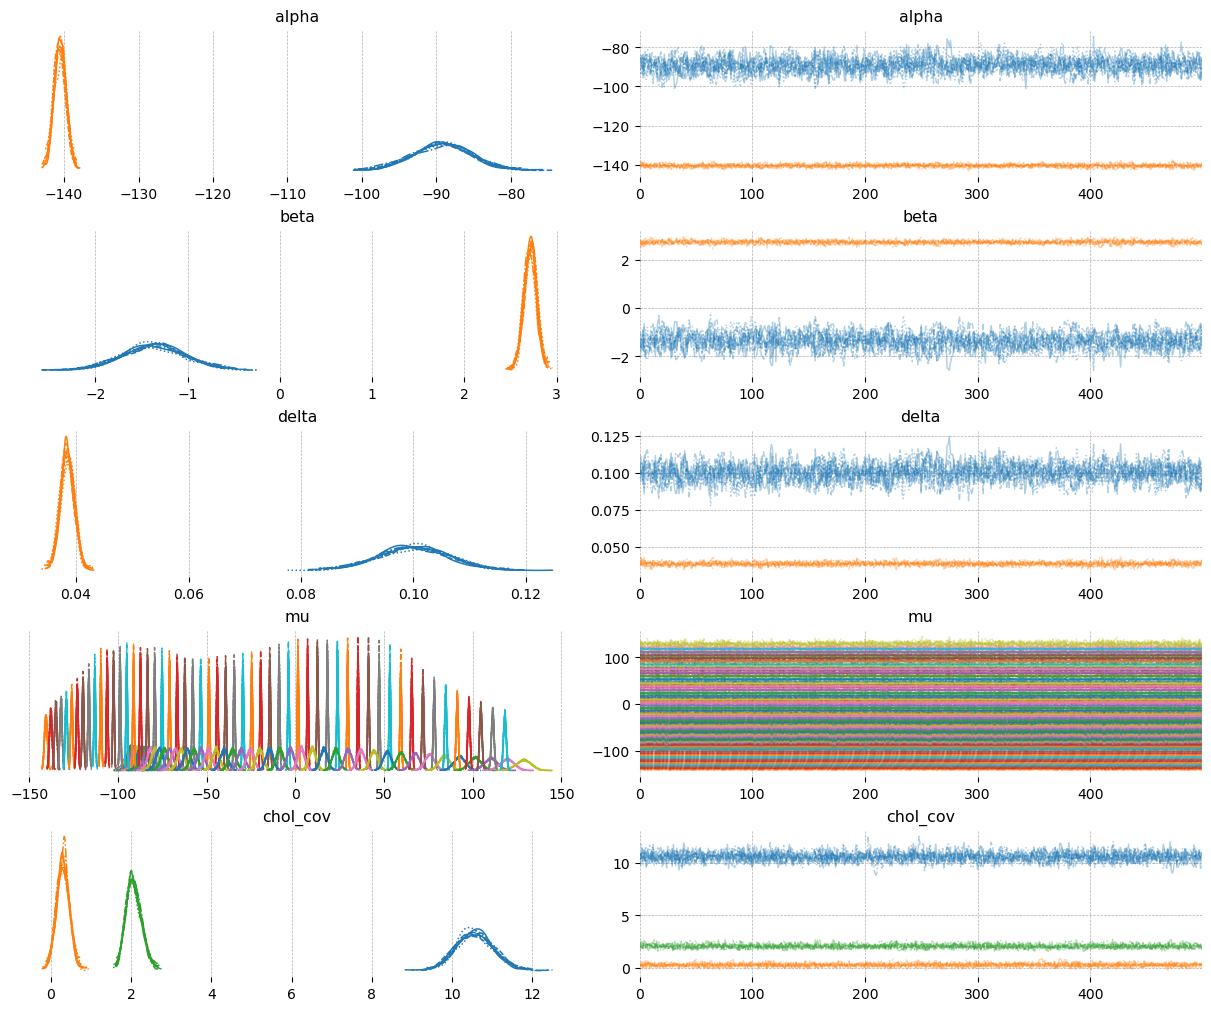

In [66]:
az.plot_trace(SUR_idata, var_names=['alpha', 'beta', 'delta', 'mu', 'chol_cov']);

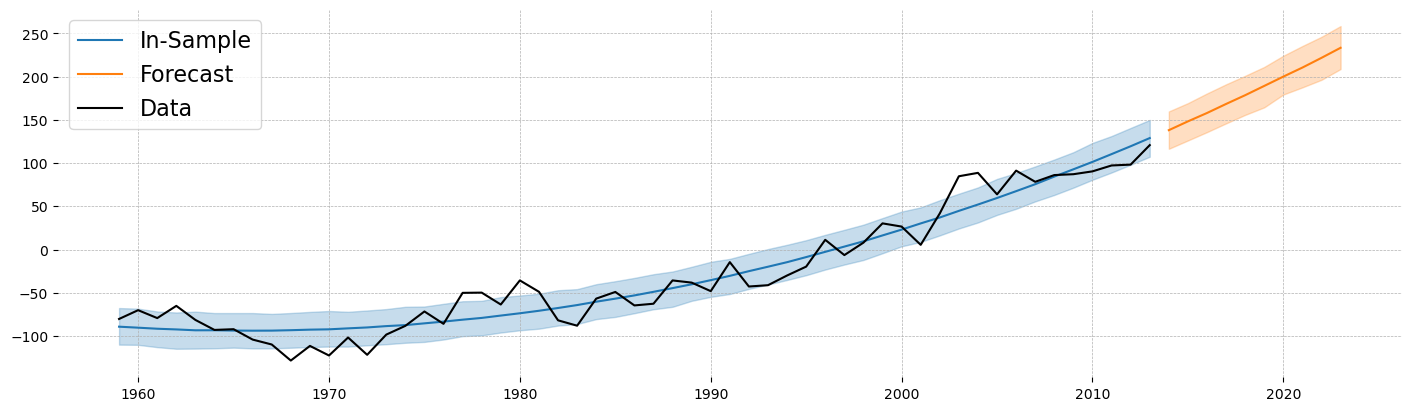

In [67]:
plot_predictions(SUR_idata, 'ocean_temp')

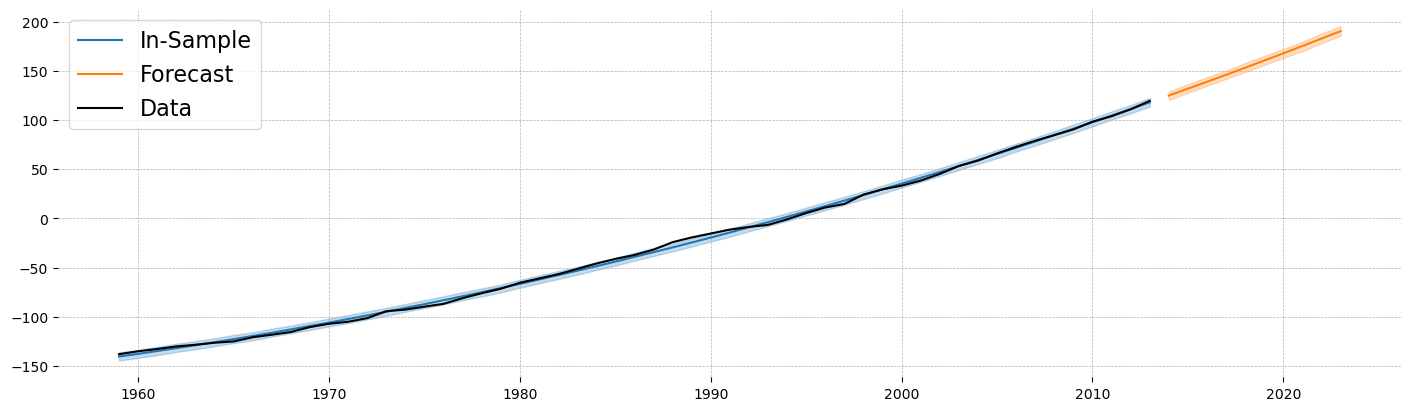

In [68]:
plot_predictions(SUR_idata, 'co2')

In [73]:
corr_samples = SUR_idata.posterior['chol_cov_corr'].values

corr_errors = corr_samples[:, :, 0, 1]  # Extracts the (1, 2) element of the correlation matrix
corr_errors_flat = corr_errors.flatten()

mean_corr_errors = np.mean(corr_errors_flat)
print("Mean correlation of the errors between Temp and CO2:", mean_corr_errors)

hdi_bounds = az.hdi(corr_errors_flat, hdi_prob=0.95)  # 95% HDI
print("95% HDI for the correlation of the errors between Temp and CO2:", hdi_bounds)


Mean correlation of the errors between Temp and CO2: 0.14601606302151016
95% HDI for the correlation of the errors between Temp and CO2: [-0.00369894  0.29181251]


# Exponential Smoothing

In [144]:
from pymc.pytensorf import collect_default_updates, get_mode

def _hw_step(l_tm1, b_tm1, y_tm1, alpha, beta, phi, sigma):
    """
    Common computational logic between the conditional and unconditonal cases
    """
    l = alpha * y_tm1 + (1 - alpha) * (l_tm1 + phi * b_tm1) # update the level
    b = beta * (l - l_tm1) + (1 - beta) * phi * b_tm1 # update the trend

    mu = l + phi * b # forecast
    y = pm.Normal.dist(mu=mu, sigma=sigma)
    
    return l, b, y


def holt_winters_step(*args):
    """
    In this case, y_tm1 comes in as outputs_info. 
    """
    l_tm1, b_tm1, y_tm1, alpha, beta, phi, sigma = args
    l, b, y = _hw_step(l_tm1, b_tm1, y_tm1, alpha, beta, phi, sigma)

    return (l, b, y), collect_default_updates(inputs=args, outputs=[y]) 
    
    
def holt_winters(alpha, beta, phi, sigma, l0, b0, y0, size, n_steps):
    (l, b, y), updates = pytensor.scan(fn=holt_winters_step,
                                       outputs_info=[l0, b0, y0],
                                       non_sequences=[alpha, beta, phi, sigma],
                                       strict=True, 
                                       n_steps=n_steps)
    
    return y

In [162]:
from scipy import linalg
T_seasonal = np.eye(6, k=-1)
T_seasonal[0, :] = -1
T_components = [np.eye(1), np.eye(1), T_seasonal]
T = linalg.block_diag(*T_components)

In [275]:
import sympy as sp

In [277]:
f = sp.Function('f')
x = sp.Symbol('x')

In [280]:
f(sp.exp(x)).diff(x)

exp(x)*Subs(Derivative(f(_xi_1), _xi_1), _xi_1, exp(x))

In [156]:
# %debug

from functools import partial
with pm.Model(coords=coords) as holt_winters_model:
#     y = pm.Data('y', df.values, dims=['time', 'variable'])
    alpha = pm.Uniform('alpha', 0, 1, dims=['variable'])
    beta = pm.Uniform('beta', 0, 1, dims=['variable'])
    phi = pm.Uniform('phi', 0.8, 0.98, dims=['variable'])
    sigma = pm.HalfNormal('sigma', 0.1, dims=['variable'])
    
    l0 = pm.Normal('l0', 0, 0.1, dims=['variable']) # initial level
    b0 = pm.Normal('b0', 0, 0.1, dims=['variable']) # initial trend
    y0 = pm.Normal('y0', 0, 0.1, dims=['variable']) # initial observation
        
    y_hat = pm.CustomDist('y_hat', alpha, beta, phi, sigma, l0, b0, y0, 
                          dist=partial(holt_winters, n_steps=df.shape[0]), 
                          observed=df.values,
                          dims=['time', 'variable'],
                          signature='(n),(n),(n),(n),(n),(n),(n)->(t,n)') 
    
    idata = pm.sample(nuts_sampler='pymc', chains=8, draws=500)
    # I could have appended y0 to y_hat, but we don't ever observe it so I didn't 
#     idata = pm.sample_prior_predictive(random_seed=rng)

(False,)
(False,)


AssertionError: 

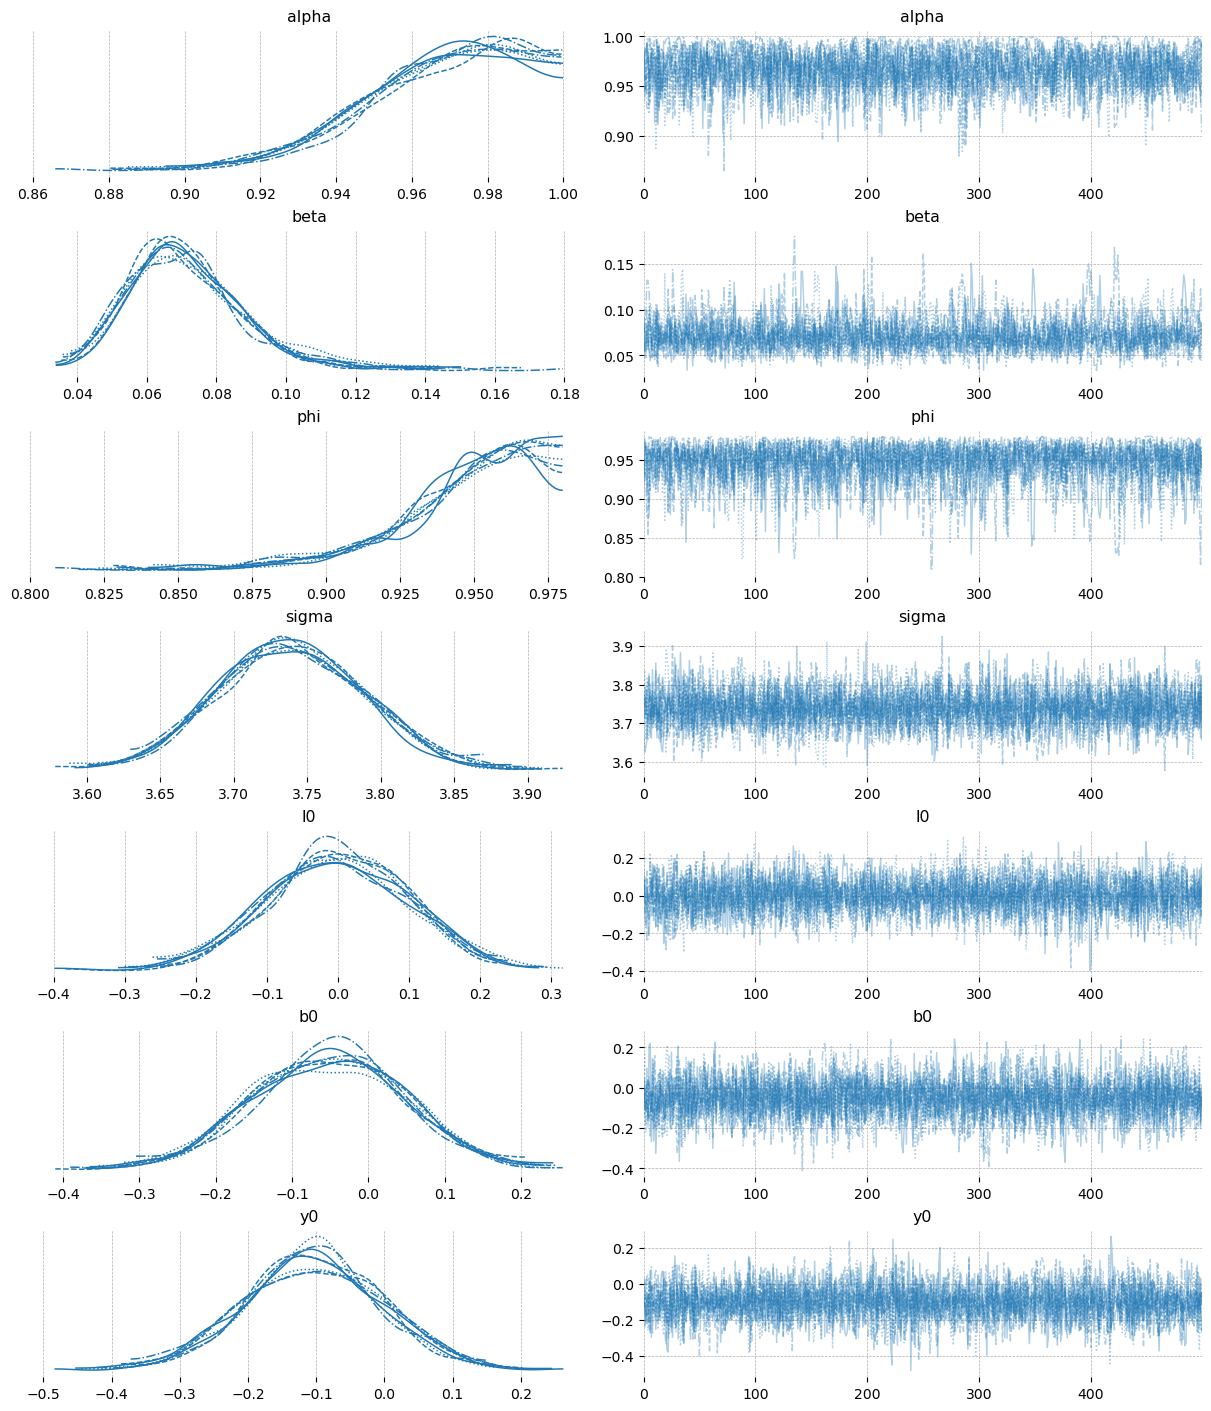

In [122]:
az.plot_trace(idata, var_names=[x.name for x in holt_winters_model.basic_RVs[:-1]]);